In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import zipfile
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataframe_interlagos = pd.read_csv("/content/drive/My Drive/dataframe_interlagos.csv")

In [ ]:
# Ordenar o dataframe por Data e Hora
dataframe_interlagos = dataframe_interlagos.sort_values(by=['Data', 'Hora'])

In [ ]:
# Garantindo que a coluna 'Data' está no formato datetime
dataframe_interlagos['Data'] = pd.to_datetime(dataframe_interlagos['Data'])

# Filtrando os dados a partir de 2020
dataframe_interlagos = dataframe_interlagos[dataframe_interlagos['Data'].dt.year >= 2020]

In [ ]:
# Convertendo as colunas para números (ignora erros caso haja valores não numéricos)
colunas_numericas = ['Temperatura', 'Umidade', 'Precipitacao']
for coluna in colunas_numericas:
    dataframe_interlagos[coluna] = pd.to_numeric(dataframe_interlagos[coluna], errors='coerce')

In [ ]:
# Cópia de segurança
df = dataframe_interlagos.copy()

# Unificar data e hora em uma coluna datetime completa
df['Data_Hora'] = pd.to_datetime(df['Data'].astype(str) + ' ' + df['Hora'].str.replace(' UTC', '').str[:2] + ':00')

# Reorganiza colunas para facilitar visualização
df = df[['Data_Hora'] + [col for col in df.columns if col != 'Data_Hora']]

# Define a nova coluna como índice
df.set_index('Data_Hora', inplace=True)

# Corrigir vírgulas nos dados numéricos
colunas_com_virgula = df.columns[df.dtypes == 'object']

for col in colunas_com_virgula:
    df[col] = df[col].str.replace(',', '.', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Verificar dados faltantes
print("Valores nulos por coluna:")
print(df.isnull().sum().sort_values(ascending=False))

# Criar colunas auxiliares de data
df['ano'] = df.index.year
df['mes'] = df.index.month
df['dia'] = df.index.day
df['hora'] = df.index.hour
df['dia_semana'] = df.index.dayofweek  # 0=segunda, 6=domingo

Valores nulos por coluna:
RADIACAO GLOBAL (KJ/m²)                                  44592
Estacao                                                  44592
Codigo_WMO                                               44592
Hora                                                     44592
Data_Fundacao                                            44592
Temperatura                                              40189
RADIACAO GLOBAL (Kj/m²)                                  20452
Precipitacao                                              4509
VENTO, RAJADA MAXIMA (m/s)                                3476
Velocidade_Vento                                          3459
VENTO, DIREÇÃO HORARIA (gr) (° (gr))                      3458
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)          1535
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)          1530
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                  1527
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                  1527
TEMPERATURA DO PONTO DE ORVAL

In [ ]:
# Remove colunas inúteis ou quase 100% nulas
colunas_remover = [
    'Estacao', 'Codigo_WMO', 'Hora', 'Data_Fundacao',
    'RADIACAO GLOBAL (KJ/m²)'  # duplicada e mais nula que a outra
]
df.drop(columns=colunas_remover, inplace=True)

# Interpolação linear para colunas numéricas principais
colunas_para_interpolar = [
    'Temperatura', 'Umidade', 'Velocidade_Vento', 'Precipitacao',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
    'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
    'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
    'RADIACAO GLOBAL (Kj/m²)'
]

df[colunas_para_interpolar] = df[colunas_para_interpolar].interpolate(method='linear', limit_direction='both')

# Preencher nulos restantes com a média ou outro valor aceitável
df.fillna(df.mean(numeric_only=True), inplace=True)

# Checar se ainda restam nulos
print("Nulos restantes:")
print(df.isnull().sum().sort_values(ascending=False).head(10))

Nulos restantes:
Precipitacao                                             0
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)    0
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)          0
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)         0
RADIACAO GLOBAL (Kj/m²)                                  0
Temperatura                                              0
TEMPERATURA DO PONTO DE ORVALHO (°C)                     0
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)               0
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)               0
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)         0
dtype: int64


In [ ]:
# Remover colunas indesejadas
df = df.drop(columns=['Latitude', 'Longitude', 'Altitude'])

In [ ]:
# Converter índice para datetime, se ainda não estiver
df.index = pd.to_datetime(df.index)

# Agregar médias mensais de temperatura e precipitação
df_mes = df.resample('M')[['Temperatura', 'Precipitacao']].mean()

# Visualizar as primeiras linhas
print(df_mes.head())

            Temperatura  Precipitacao
Data_Hora                            
2020-01-31    22.332885      0.160618
2020-02-29    21.254071      0.334770
2020-03-31    20.509697      0.032930
2020-04-30    19.056647      0.000000
2020-05-31    16.899418      0.008065


<ipython-input-12-3bc41658dc76>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mes = df.resample('M')[['Temperatura', 'Precipitacao']].mean()


SARIMA

In [ ]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 25.2 MB/s eta 0:00:00


<ipython-input-15-ca09ed4db596>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  real_idx = pd.date_range('2024-02-28', periods=12, freq='M')
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to 

SARIMA (Temp) FEV24–JAN25 — MAE: 1.332, RMSE: 1.563, MAPE: 6.830%
SARIMA (Prec) FEV24–JAN25 — MAE: 0.097, RMSE: 0.129, MAPE: 335.918%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


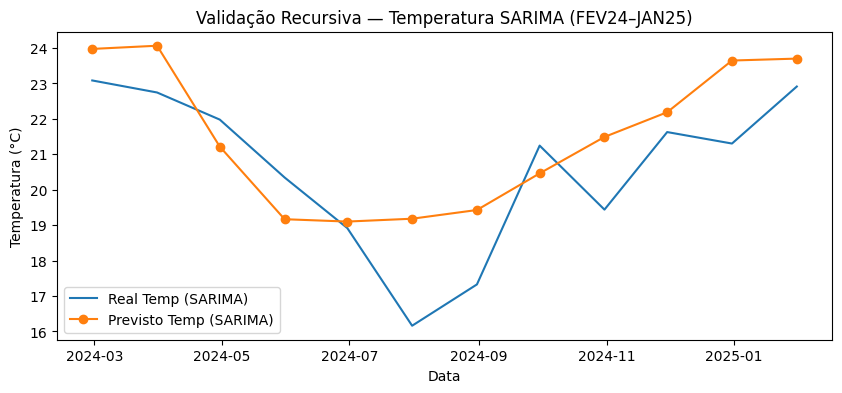

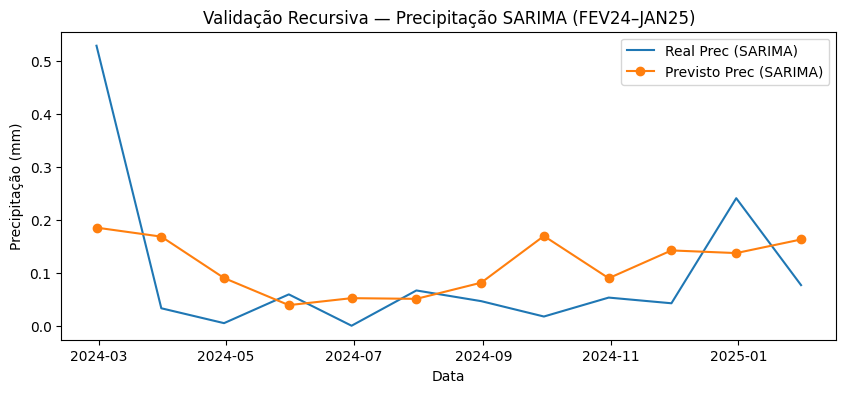

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Preparar os dados de validação
# df_mes: DataFrame mensal com índice DatetimeIndex fim de mês, colunas ['Temperatura','Precipitacao']
# Definir período de validação
real_idx = pd.date_range('2024-02-28', periods=12, freq='M')

# Extrair a parte de teste de df_mes
test = df_mes.loc['2024-02':'2025-01']

real_temp = test['Temperatura'].reindex(real_idx)
real_prec = test['Precipitacao'].reindex(real_idx)

# Inicializar df_roll com todo o histórico até jan/2024
# Cópia para injeção recursiva
df_roll = df_mes.copy()

# Parâmetros SARIMA
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Listas para previsões
pred_temp = []
pred_prec = []

# Loop recursivo mês a mês
for ds in real_idx:
    # Série histórica até mês anterior
    last_month = ds - pd.offsets.MonthEnd(1)
    hist_temp = df_roll['Temperatura'][:last_month]
    hist_prec = df_roll['Precipitacao'][:last_month]

    # Ajustar SARIMA em cada uma
    mod_t = sm.tsa.SARIMAX(
        hist_temp,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    mod_p = sm.tsa.SARIMAX(
        hist_prec,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # Forecast de 1 passo
    fc_t = mod_t.get_forecast(steps=1).predicted_mean.iloc[0]
    fc_p = mod_p.get_forecast(steps=1).predicted_mean.iloc[0]

    pred_temp.append(fc_t)
    pred_prec.append(fc_p)

    # Injetar no histórico
    df_roll.at[ds, 'Temperatura'] = fc_t
    df_roll.at[ds, 'Precipitacao'] = fc_p

# Converter em Series
pred_temp = pd.Series(pred_temp, index=real_idx, name='Temp_FC')
pred_prec = pd.Series(pred_prec, index=real_idx, name='Prec_FC')

# Calcular métricas
mae_t  = mean_absolute_error(real_temp, pred_temp)
rmse_t = np.sqrt(mean_squared_error(real_temp, pred_temp))
mape_t = (np.abs((real_temp - pred_temp) / real_temp)
          .replace(np.inf, np.nan).dropna().mean()) * 100

mae_p  = mean_absolute_error(real_prec, pred_prec)
rmse_p = np.sqrt(mean_squared_error(real_prec, pred_prec))
mape_p = (np.abs((real_prec - pred_prec) / real_prec)
          .replace(np.inf, np.nan).dropna().mean()) * 100

print(f"SARIMA (Temp) FEV24–JAN25 — MAE: {mae_t:.3f}, RMSE: {rmse_t:.3f}, MAPE: {mape_t:.3f}%")
print(f"SARIMA (Prec) FEV24–JAN25 — MAE: {mae_p:.3f}, RMSE: {rmse_p:.3f}, MAPE: {mape_p:.3f}%")

# Plot no formato padronizado
plt.figure(figsize=(10,4))
plt.plot(real_idx, real_temp,  '-',  label='Real Temp (SARIMA)',    color='tab:blue')
plt.plot(real_idx, pred_temp, 'o-',  label='Previsto Temp (SARIMA)', color='tab:orange')
plt.title("Validação Recursiva — Temperatura SARIMA (FEV24–JAN25)")
plt.xlabel("Data"); plt.ylabel("Temperatura (°C)")
plt.legend(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(real_idx, real_prec,  '-',  label='Real Prec (SARIMA)',    color='tab:blue')
plt.plot(real_idx, pred_prec, 'o-',  label='Previsto Prec (SARIMA)', color='tab:orange')
plt.title("Validação Recursiva — Precipitação SARIMA (FEV24–JAN25)")
plt.xlabel("Data"); plt.ylabel("Precipitação (mm)")
plt.legend(); plt.show()

Holt–Winters

Holt–Winters (Temp) — MAE: 0.968, RMSE: 1.096, MAPE: 4.900%
Holt–Winters (Prec) — MAE: 0.087, RMSE: 0.111, MAPE: 249.382%


<ipython-input-16-ff68047d23c5>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  real_idx  = pd.date_range('2024-02-28', periods=12, freq='M')


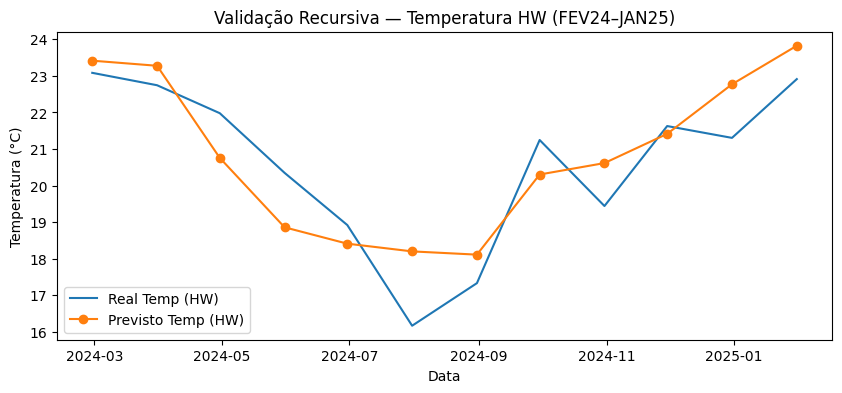

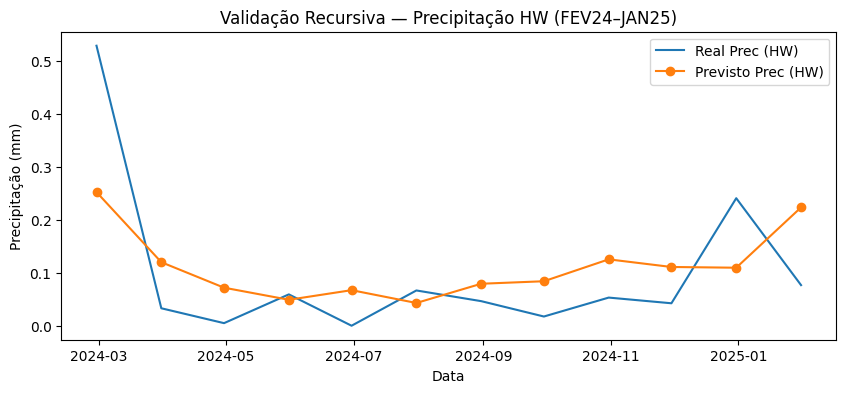

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Partir do df_mes mensal (jan/2020 até jan/2025)
# Índice DatetimeIndex no fim de cada mês, colunas ['Temperatura','Precipitacao']

# Definir train e test
train  = df_mes.loc[: '2024-01-31']
test   = df_mes.loc['2024-02-01': '2025-01-31']

# Índice de validação fim‑de‑mês fev/24–jan/25
real_idx  = pd.date_range('2024-02-28', periods=12, freq='M')

# Series de valores reais, reindexadas em real_idx
real_temp = test['Temperatura'].reindex(real_idx)
real_prec = test['Precipitacao'].reindex(real_idx)

# Ajustar Holt–Winters nos dados até jan/2024
hw_temp = ExponentialSmoothing(
    train['Temperatura'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

hw_prec = ExponentialSmoothing(
    train['Precipitacao'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

# Forecast recursivo de 12 meses (FEV24–JAN25)
# Para Holt–Winters, forecast(12) já faz recursão internamente:
pred_temp = hw_temp.forecast(12).reindex(real_idx)
pred_prec = hw_prec.forecast(12).reindex(real_idx)

# Calcular métricas
mae_t  = mean_absolute_error(real_temp, pred_temp)
rmse_t = np.sqrt(mean_squared_error(real_temp, pred_temp))
mape_t = (np.abs((real_temp - pred_temp) / real_temp)
          .replace(np.inf, np.nan).dropna().mean()) * 100

mae_p  = mean_absolute_error(real_prec, pred_prec)
rmse_p = np.sqrt(mean_squared_error(real_prec, pred_prec))
mape_p = (np.abs((real_prec - pred_prec) / real_prec)
          .replace(np.inf, np.nan).dropna().mean()) * 100

print(f"Holt–Winters (Temp) — MAE: {mae_t:.3f}, RMSE: {rmse_t:.3f}, MAPE: {mape_t:.3f}%")
print(f"Holt–Winters (Prec) — MAE: {mae_p:.3f}, RMSE: {rmse_p:.3f}, MAPE: {mape_p:.3f}%")

# Plot no padrão azul contínuo vs laranja com círculos
plt.figure(figsize=(10,4))
plt.plot(real_idx, real_temp,   '-',  label='Real Temp (HW)',    color='tab:blue')
plt.plot(real_idx, pred_temp,  'o-',  label='Previsto Temp (HW)', color='tab:orange')
plt.title("Validação Recursiva — Temperatura HW (FEV24–JAN25)")
plt.xlabel("Data"); plt.ylabel("Temperatura (°C)")
plt.legend(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(real_idx, real_prec,   '-',  label='Real Prec (HW)',    color='tab:blue')
plt.plot(real_idx, pred_prec,  'o-',  label='Previsto Prec (HW)', color='tab:orange')
plt.title("Validação Recursiva — Precipitação HW (FEV24–JAN25)")
plt.xlabel("Data"); plt.ylabel("Precipitação (mm)")
plt.legend(); plt.show()

Prophet

In [ ]:
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 166.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.9/917.9 kB 63.9 MB/s eta 0:00:00


<ipython-input-19-7b4b6075e3bd>:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  real_idx  = pd.date_range('2024-02-28', periods=12, freq='M')
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcn5aduji/5vfve0xy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcn5aduji/73lipgyx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26010', 'data', 'file=/tmp/tmpcn5aduji/5vfve0xy.json', 'init=/tmp/tmpcn5aduji/73lipgyx.json', 'output', 'file=/tmp/tmpcn5aduji/prophet_modelb08hee18/prophet_model-20250503131915.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:19:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcn

Prophet (Temp) — MAE: 1.200, RMSE: 1.577, MAPE: 6.035%
Prophet (Prec) — MAE: 0.073, RMSE: 0.090, MAPE: 197.927%


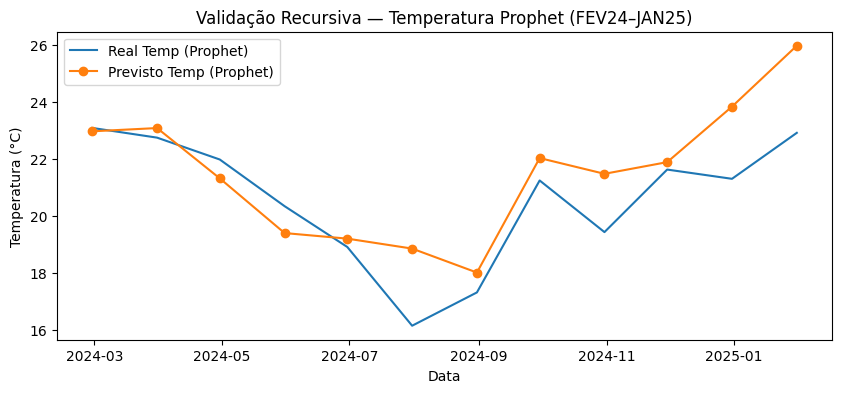

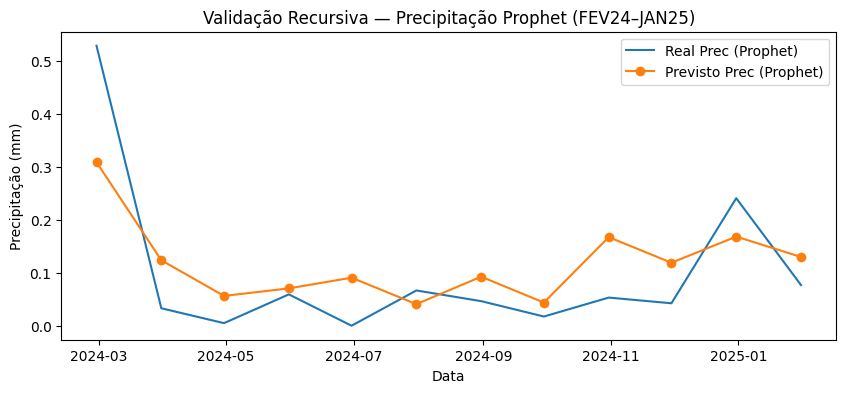

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# preparar ds/y e cortar até jan/2024
temp_df = train.reset_index().rename(columns={train.index.name or 'index':'ds','Temperatura':'y'})[['ds','y']]
prec_df = train.reset_index().rename(columns={train.index.name or 'index':'ds','Precipitacao':'y'})[['ds','y']]
cut='2024-01-31'
df_t_cut = temp_df[temp_df.ds<=cut]
df_p_cut = prec_df[prec_df.ds<=cut]

real_idx  = pd.date_range('2024-02-28', periods=12, freq='M')
real_temp = test['Temperatura'].reindex(real_idx)
real_prec = test['Precipitacao'].reindex(real_idx)

# Fit e prever in‑sample
m_t = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False).fit(df_t_cut)
m_p = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False).fit(df_p_cut)
future = m_t.make_future_dataframe(periods=12, freq='M')
pred_t = m_t.predict(future).set_index('ds')['yhat'].reindex(real_idx)
pred_p = m_p.predict(future).set_index('ds')['yhat'].reindex(real_idx)

# Métricas
def mape(a,b): return np.mean(np.abs((a-b)/a).replace(np.inf,np.nan))*100
mae_t = mean_absolute_error(real_temp, pred_t)
rmse_t = np.sqrt(mean_squared_error(real_temp, pred_t))
mape_t = mape(real_temp, pred_t)
mae_p = mean_absolute_error(real_prec, pred_p)
rmse_p = np.sqrt(mean_squared_error(real_prec, pred_p))
mape_p = mape(real_prec, pred_p)

print(f"Prophet (Temp) — MAE: {mae_t:.3f}, RMSE: {rmse_t:.3f}, MAPE: {mape_t:.3f}%")
print(f"Prophet (Prec) — MAE: {mae_p:.3f}, RMSE: {rmse_p:.3f}, MAPE: {mape_p:.3f}%")

# Gráficos
plt.figure(figsize=(10,4))
plt.plot(real_idx, real_temp,  '-', label='Real Temp (Prophet)',    color='tab:blue')
plt.plot(real_idx, pred_t,    'o-', label='Previsto Temp (Prophet)', color='tab:orange')
plt.title("Validação Recursiva — Temperatura Prophet (FEV24–JAN25)")
plt.xlabel("Data"); plt.ylabel("Temperatura (°C)"); plt.legend(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(real_idx, real_prec,  '-', label='Real Prec (Prophet)',    color='tab:blue')
plt.plot(real_idx, pred_p,    'o-', label='Previsto Prec (Prophet)', color='tab:orange')
plt.title("Validação Recursiva — Precipitação Prophet (FEV24–JAN25)")
plt.xlabel("Data"); plt.ylabel("Precipitação (mm)"); plt.legend(); plt.show()

Random Forest

<ipython-input-20-a38177d9f2a3>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  real_idx  = pd.date_range('2024-02-28', periods=12, freq='M')


RF (Temp) FEV24–JAN25 — MAE: 1.180, RMSE: 1.463, MAPE: 5.703%
RF (Prec) FEV24–JAN25 — MAE: 0.080, RMSE: 0.119, MAPE: 194.856%


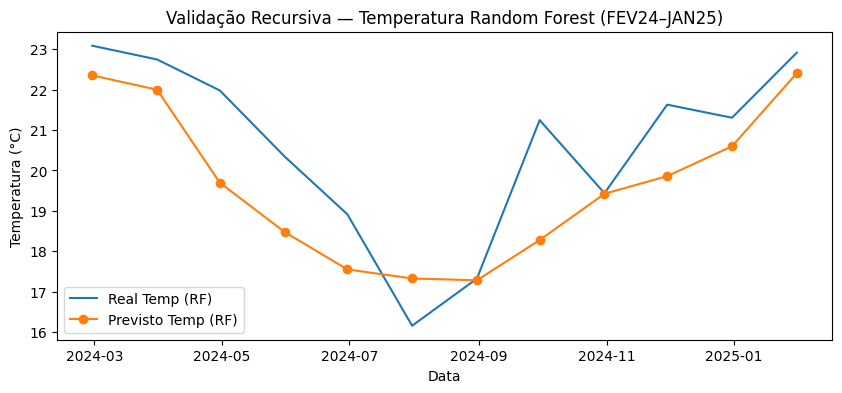

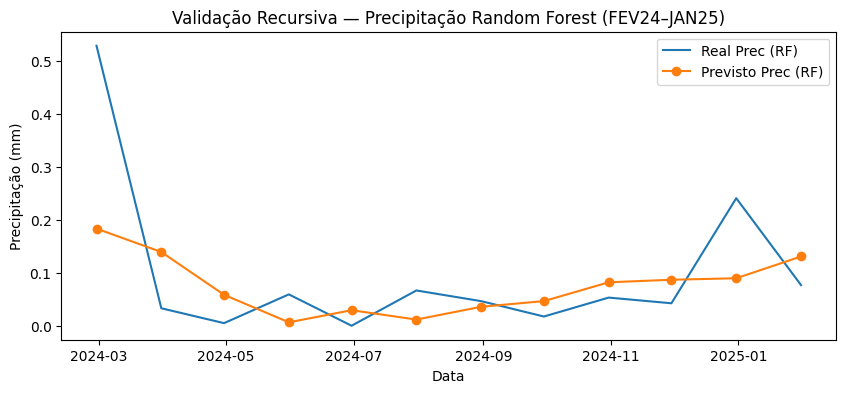

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Preparar dados
# df_mes: DataFrame mensal com índice DatetimeIndex (último dia do mês)
# colunas: ['Temperatura', 'Precipitacao'], de jan/2020 até jan/2025
# train até jan/2024, test de fev/2024 a jan/2025
end_train = '2024-01-31'
real_idx  = pd.date_range('2024-02-28', periods=12, freq='M')

train_df = df_mes.loc[:end_train].copy()
test_df  = df_mes.loc['2024-02-01':'2025-01-31'].copy()

# Feature engineering (lags e cíclicos) uma única vez sobre o df_mes completo
df_feat = df_mes.copy()
for lag in [1,2,3]:
    df_feat[f'temp_lag_{lag}'] = df_feat['Temperatura'].shift(lag)
    df_feat[f'prec_lag_{lag}'] = df_feat['Precipitacao'].shift(lag)

df_feat['month_sin'] = np.sin(2*np.pi*df_feat.index.month/12)
df_feat['month_cos'] = np.cos(2*np.pi*df_feat.index.month/12)
df_feat = df_feat.dropna()

# Preparar rolling forecast
df_roll = df_feat.loc[:end_train].copy()
temp_preds = []
prec_preds = []

# Instanciar modelos e treinar uma vez até jan/2024
feature_cols = [c for c in df_feat.columns if 'lag_' in c or c.startswith('month_')]
X_train = df_roll[feature_cols]
y_temp   = df_roll['Temperatura']
y_prec   = df_roll['Precipitacao']

model_temp = RandomForestRegressor(n_estimators=200, random_state=42)
model_prec = RandomForestRegressor(n_estimators=200, random_state=42)
model_temp.fit(X_train, y_temp)
model_prec.fit(X_train, y_prec)

# Loop recursivo para cada mês de validação
for ds in real_idx:
    # montar as features do mês ds
    feats = {}
    for lag in [1,2,3]:
        prev = ds - pd.offsets.MonthEnd(lag)
        feats[f'temp_lag_{lag}'] = df_roll.at[prev, 'Temperatura']
        feats[f'prec_lag_{lag}'] = df_roll.at[prev, 'Precipitacao']
    feats['month_sin'] = np.sin(2*np.pi*ds.month/12)
    feats['month_cos'] = np.cos(2*np.pi*ds.month/12)

    X_new = pd.DataFrame([feats], index=[ds])
    X_new = X_new[feature_cols]  # garantir mesma ordem

    # prever
    t_hat = model_temp.predict(X_new)[0]
    p_hat = model_prec.predict(X_new)[0]
    temp_preds.append(t_hat)
    prec_preds.append(p_hat)

    # injetar no histórico para próximas iterações
    df_roll.at[ds, 'Temperatura']  = t_hat
    df_roll.at[ds, 'Precipitacao'] = p_hat

# Converter em Series e extrair valores reais
pred_temp = pd.Series(temp_preds, index=real_idx, name='RF_FC_Temp')
pred_prec = pd.Series(prec_preds, index=real_idx, name='RF_FC_Prec')

real_temp = test_df['Temperatura'].reindex(real_idx)
real_prec = test_df['Precipitacao'].reindex(real_idx)

# Calcular métricas
def metr(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = (np.abs((y_true - y_pred) / y_true)
            .replace(np.inf, np.nan).dropna().mean()) * 100
    return mae, rmse, mape

mae_t, rmse_t, mape_t = metr(real_temp, pred_temp)
mae_p, rmse_p, mape_p = metr(real_prec, pred_prec)

print(f"RF (Temp) FEV24–JAN25 — MAE: {mae_t:.3f}, RMSE: {rmse_t:.3f}, MAPE: {mape_t:.3f}%")
print(f"RF (Prec) FEV24–JAN25 — MAE: {mae_p:.3f}, RMSE: {rmse_p:.3f}, MAPE: {mape_p:.3f}%")

# Plot padronizado
plt.figure(figsize=(10,4))
plt.plot(real_idx, real_temp,  '-', label='Real Temp (RF)',    color='tab:blue')
plt.plot(real_idx, pred_temp, 'o-', label='Previsto Temp (RF)', color='tab:orange')
plt.title("Validação Recursiva — Temperatura Random Forest (FEV24–JAN25)")
plt.xlabel("Data"); plt.ylabel("Temperatura (°C)"); plt.legend(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(real_idx, real_prec,  '-', label='Real Prec (RF)',    color='tab:blue')
plt.plot(real_idx, pred_prec, 'o-', label='Previsto Prec (RF)', color='tab:orange')
plt.title("Validação Recursiva — Precipitação Random Forest (FEV24–JAN25)")
plt.xlabel("Data"); plt.ylabel("Precipitação (mm)"); plt.legend(); plt.show()

XGBoost (XGB)

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 1.2 MB/s eta 0:00:00


<ipython-input-23-c659107285ef>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  real_idx  = pd.date_range('2024-02-28', periods=12, freq='M')


XGB (Temp) FEV24–JAN25 — MAE: 1.520, RMSE: 1.780, MAPE: 7.417%
XGB (Prec) FEV24–JAN25 — MAE: 0.055, RMSE: 0.085, MAPE: 81.461%


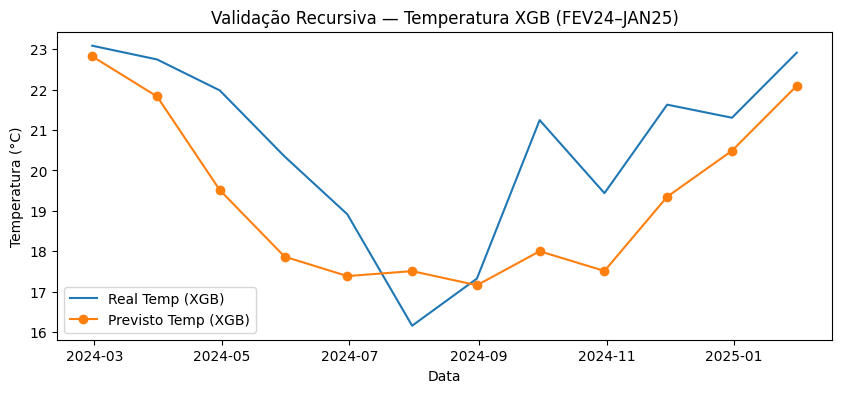

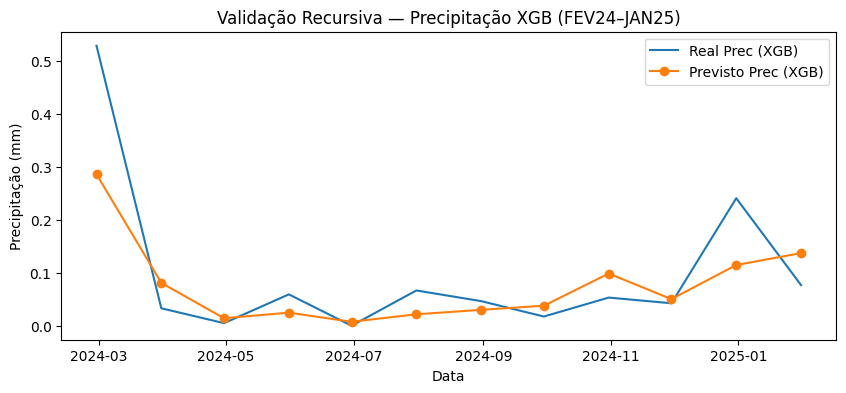

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Preparar dados
# df_mes: DataFrame mensal com índice DatetimeIndex (último dia do mês)
# colunas: ['Temperatura','Precipitacao'], de jan/2020 até jan/2025
end_train = '2024-01-31'
real_idx  = pd.date_range('2024-02-28', periods=12, freq='M')

train_df = df_mes.loc[:end_train].copy()
test_df  = df_mes.loc['2024-02-01':'2025-01-31'].copy()

# Feature engineering (lags e cíclicos) sobre o df_mes completo
df_feat = df_mes.copy()
for lag in [1,2,3]:
    df_feat[f'temp_lag_{lag}'] = df_feat['Temperatura'].shift(lag)
    df_feat[f'prec_lag_{lag}'] = df_feat['Precipitacao'].shift(lag)
df_feat['month_sin'] = np.sin(2*np.pi*df_feat.index.month/12)
df_feat['month_cos'] = np.cos(2*np.pi*df_feat.index.month/12)
df_feat = df_feat.dropna()

# Rolling forecast setup
df_roll = df_feat.loc[:end_train].copy()
feat_cols = [c for c in df_feat.columns if 'lag_' in c or c.startswith('month_')]
xgb_temp = XGBRegressor(n_estimators=200, random_state=42)
xgb_prec = XGBRegressor(n_estimators=200, random_state=42)

# Treinar uma vez até jan/2024
X_init = df_roll[feat_cols]
y_temp_init = df_roll['Temperatura']
y_prec_init = df_roll['Precipitacao']
xgb_temp.fit(X_init, y_temp_init)
xgb_prec.fit(X_init, y_prec_init)

# Previsão recursiva mes a mes
temp_preds, prec_preds = [], []
for ds in real_idx:
    # montar features de ds
    row = {}
    for lag in [1,2,3]:
        prev = ds - pd.offsets.MonthEnd(lag)
        row[f'temp_lag_{lag}'] = df_roll.at[prev, 'Temperatura']
        row[f'prec_lag_{lag}'] = df_roll.at[prev, 'Precipitacao']
    row['month_sin'] = np.sin(2*np.pi*ds.month/12)
    row['month_cos'] = np.cos(2*np.pi*ds.month/12)

    X_new = pd.DataFrame([row], index=[ds])[feat_cols]
    t_hat = xgb_temp.predict(X_new)[0]
    p_hat = xgb_prec.predict(X_new)[0]
    temp_preds.append(t_hat)
    prec_preds.append(p_hat)

    # injetar no histórico
    df_roll.at[ds, 'Temperatura']  = t_hat
    df_roll.at[ds, 'Precipitacao'] = p_hat

# Converter e extrair reais
pred_temp = pd.Series(temp_preds, index=real_idx, name='XGB_FC_Temp')
pred_prec = pd.Series(prec_preds, index=real_idx, name='XGB_FC_Prec')
real_temp = test_df['Temperatura'].reindex(real_idx)
real_prec = test_df['Precipitacao'].reindex(real_idx)

# Métricas
def metr(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = (np.abs((y_true - y_pred) / y_true)
            .replace(np.inf, np.nan).dropna().mean()) * 100
    return mae, rmse, mape

mae_t, rmse_t, mape_t = metr(real_temp, pred_temp)
mae_p, rmse_p, mape_p = metr(real_prec, pred_prec)

print(f"XGB (Temp) FEV24–JAN25 — MAE: {mae_t:.3f}, RMSE: {rmse_t:.3f}, MAPE: {mape_t:.3f}%")
print(f"XGB (Prec) FEV24–JAN25 — MAE: {mae_p:.3f}, RMSE: {rmse_p:.3f}, MAPE: {mape_p:.3f}%")

# Plot padronizado
plt.figure(figsize=(10,4))
plt.plot(real_idx, real_temp,  '-', label='Real Temp (XGB)',    color='tab:blue')
plt.plot(real_idx, pred_temp, 'o-', label='Previsto Temp (XGB)', color='tab:orange')
plt.title("Validação Recursiva — Temperatura XGB (FEV24–JAN25)")
plt.xlabel("Data"); plt.ylabel("Temperatura (°C)"); plt.legend(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(real_idx, real_prec,  '-', label='Real Prec (XGB)',    color='tab:blue')
plt.plot(real_idx, pred_prec, 'o-', label='Previsto Prec (XGB)', color='tab:orange')
plt.title("Validação Recursiva — Precipitação XGB (FEV24–JAN25)")
plt.xlabel("Data"); plt.ylabel("Precipitação (mm)"); plt.legend(); plt.show()

LightGBM (LGB)

In [ ]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 38.6 MB/s eta 0:00:00


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 8
[LightGBM] [Info] Start training from score 19.442349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

<ipython-input-26-41b054bf4526>:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  real_idx = pd.date_range('2024-02-28', periods=12, freq='M')


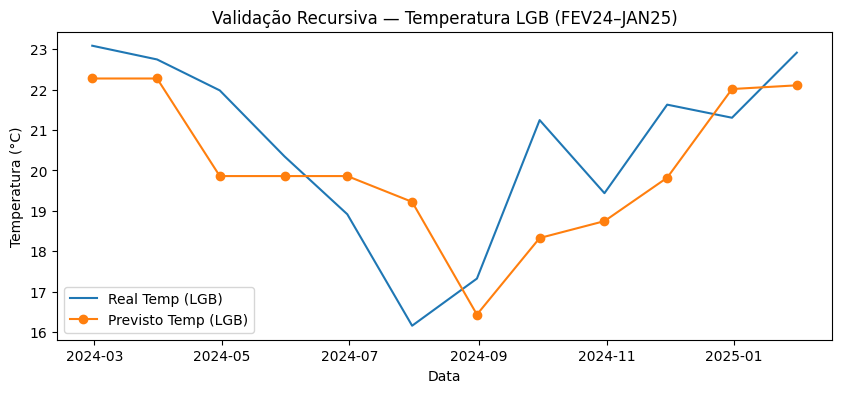

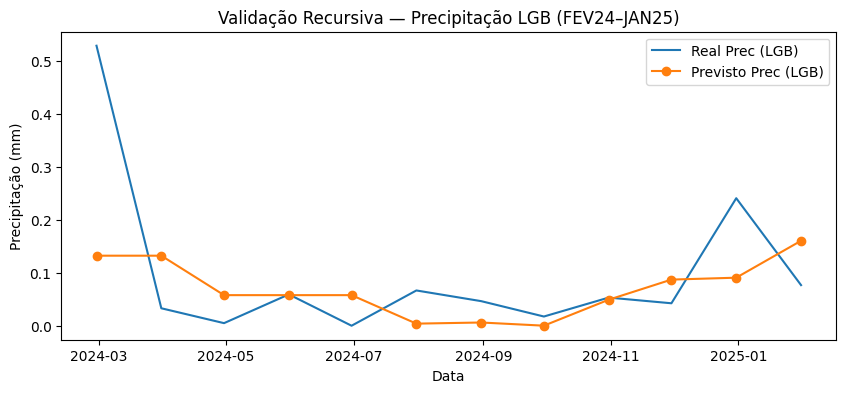

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Preparar df_feat (jan/2020 até jan/2025)
# Supondo que df_mes já exista, com índice DatetimeIndex fim‑de‑mês e colunas ['Temperatura','Precipitacao']
df_feat = df_mes.copy()

# criar lags 1–3 e variáveis cíclicas de mês
for lag in [1,2,3]:
    df_feat[f'temp_lag_{lag}'] = df_feat['Temperatura'].shift(lag)
    df_feat[f'prec_lag_{lag}'] = df_feat['Precipitacao'].shift(lag)
df_feat['month_sin'] = np.sin(2*np.pi*df_feat.index.month/12)
df_feat['month_cos'] = np.cos(2*np.pi*df_feat.index.month/12)
df_feat = df_feat.dropna()

# Dividir treino/teste
train_feat = df_feat.loc[: '2024-01-31']
test_feat  = df_feat.loc['2024-02-01':'2025-01-31']

# índice de validação fim‑de‑mês fev/24–jan/25
real_idx = pd.date_range('2024-02-28', periods=12, freq='M')

# definir X_train, y_train para cada target
feature_cols = [c for c in df_feat.columns if 'lag' in c or 'month_' in c]
X_train     = train_feat[feature_cols]
y_t_train   = train_feat['Temperatura']
y_p_train   = train_feat['Precipitacao']

# séries reais para validação
real_temp = test_feat['Temperatura'].reindex(real_idx)
real_prec = test_feat['Precipitacao'].reindex(real_idx)

# Treinar LightGBM
lgb_t = LGBMRegressor(n_estimators=200, random_state=42).fit(X_train, y_t_train)
lgb_p = LGBMRegressor(n_estimators=200, random_state=42).fit(X_train, y_p_train)

# Previsão recursiva
df_roll = train_feat.copy()
pred_t, pred_p = [], []

for ds in real_idx:
    # montar dicionário de features igual ao treino
    feats = {}
    for col in feature_cols:
        if col.startswith('temp_lag'):
            lag = int(col.split('_')[-1])
            prev = ds - pd.offsets.MonthEnd(lag)
            feats[col] = df_roll.at[prev, 'Temperatura']
        elif col.startswith('prec_lag'):
            lag = int(col.split('_')[-1])
            prev = ds - pd.offsets.MonthEnd(lag)
            feats[col] = df_roll.at[prev, 'Precipitacao']
        elif col == 'month_sin':
            feats[col] = np.sin(2*np.pi*ds.month/12)
        else:  # month_cos
            feats[col] = np.cos(2*np.pi*ds.month/12)

    X_new = pd.DataFrame([feats], index=[ds])
    t_hat = lgb_t.predict(X_new)[0]
    p_hat = lgb_p.predict(X_new)[0]
    pred_t.append(t_hat)
    pred_p.append(p_hat)

    # injetar no rolling
    df_roll.at[ds, 'Temperatura']  = t_hat
    df_roll.at[ds, 'Precipitacao'] = p_hat

pred_t = pd.Series(pred_t, index=real_idx, name='Pred_Temp')
pred_p = pd.Series(pred_p, index=real_idx, name='Pred_Prec')

# Métricas
def metr(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = (np.abs((y_true - y_pred) / y_true)
            .replace(np.inf, np.nan).dropna().mean()) * 100
    return mae, rmse, mape

mae_t, rmse_t, mape_t = metr(real_temp, pred_t)
mae_p, rmse_p, mape_p = metr(real_prec, pred_p)

print(f"LGB (Temp) — MAE: {mae_t:.3f}, RMSE: {rmse_t:.3f}, MAPE: {mape_t:.3f}%")
print(f"LGB (Prec) — MAE: {mae_p:.3f}, RMSE: {rmse_p:.3f}, MAPE: {mape_p:.3f}%")

# Plot no padrão azul contínuo vs laranja com círculos

# Temperatura
plt.figure(figsize=(10,4))
plt.plot(real_idx, real_temp,   '-',  label='Real Temp (LGB)',    color='tab:blue')
plt.plot(real_idx, pred_t,     'o-',  label='Previsto Temp (LGB)', color='tab:orange')
plt.title("Validação Recursiva — Temperatura LGB (FEV24–JAN25)")
plt.xlabel("Data"); plt.ylabel("Temperatura (°C)")
plt.legend(); plt.show()

# Precipitação
plt.figure(figsize=(10,4))
plt.plot(real_idx, real_prec,   '-',  label='Real Prec (LGB)',    color='tab:blue')
plt.plot(real_idx, pred_p,     'o-',  label='Previsto Prec (LGB)', color='tab:orange')
plt.title("Validação Recursiva — Precipitação LGB (FEV24–JAN25)")
plt.xlabel("Data"); plt.ylabel("Precipitação (mm)")
plt.legend(); plt.show()

CatBoostRegressor

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.8 MB/s eta 0:00:00


CatBoost (Temp) — MAE: 1.369, RMSE: 1.636, MAPE: 6.660%
CatBoost (Prec) — MAE: 0.091, RMSE: 0.144, MAPE: 153.076%


<ipython-input-28-e7327eecda1a>:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_idx = pd.date_range('2024-02-01', periods=12, freq='M')


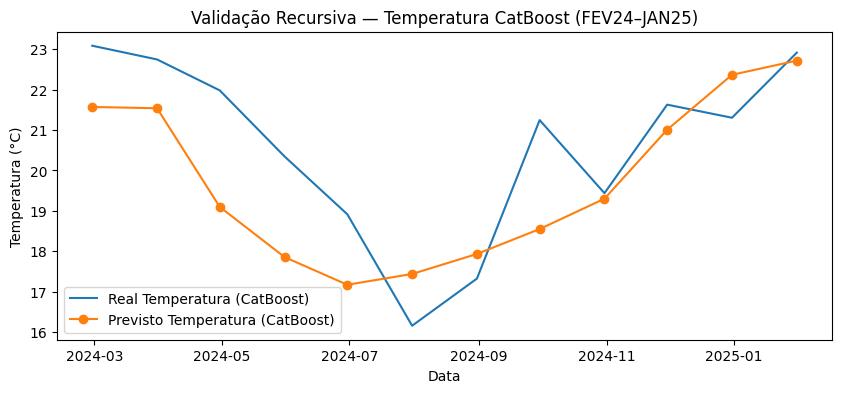

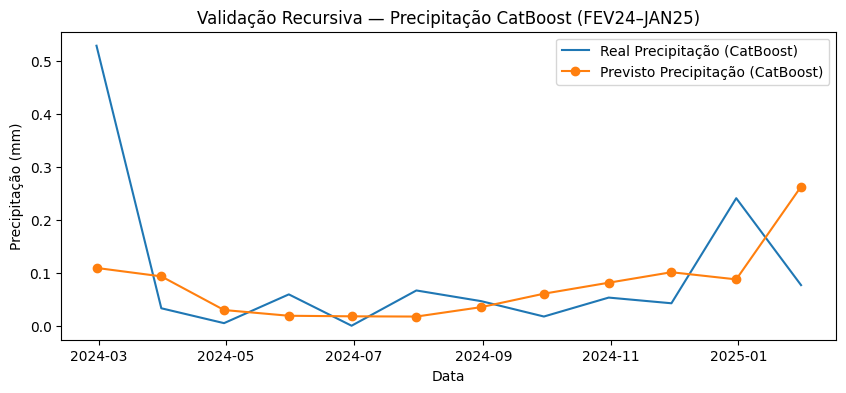

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# df_feat já preparado com lags 1–3 e month_sin/month_cos
# df_feat.index = DatetimeIndex mês‑fim de jan/2020 a jan/2024

# split treino/teste
train_feat = df_feat.loc[:'2024-01-31']
test_feat  = df_feat.loc['2024-02-01':'2025-01-31']

X_train = train_feat.drop(['Temperatura','Precipitacao'], axis=1)
y_t_train = train_feat['Temperatura']
y_p_train = train_feat['Precipitacao']

# instanciar e treinar
cat_t = CatBoostRegressor(n_estimators=500, learning_rate=0.05, random_state=42, verbose=False)
cat_p = CatBoostRegressor(n_estimators=500, learning_rate=0.05, random_state=42, verbose=False)
cat_t.fit(X_train, y_t_train)
cat_p.fit(X_train, y_p_train)

# validação recursiva
df_roll = train_feat.copy()
forecast_idx = pd.date_range('2024-02-01', periods=12, freq='M')
pred_t, pred_p = [], []

for ds in forecast_idx:
    feat = {}
    for lag in [1,2,3]:
        prev = ds - pd.offsets.MonthEnd(lag)
        feat[f'temp_lag_{lag}'] = df_roll.at[prev,'Temperatura']
        feat[f'prec_lag_{lag}'] = df_roll.at[prev,'Precipitacao']
    m = ds.month
    feat['month_sin'] = np.sin(2*np.pi*m/12)
    feat['month_cos'] = np.cos(2*np.pi*m/12)
    X_new = pd.DataFrame([feat], index=[ds])

    t_hat = cat_t.predict(X_new)[0]
    p_hat = cat_p.predict(X_new)[0]
    pred_t.append(t_hat)
    pred_p.append(p_hat)

    df_roll.at[ds,'Temperatura']=t_hat
    df_roll.at[ds,'Precipitacao']=p_hat

pred_t = pd.Series(pred_t, index=forecast_idx)
pred_p = pd.Series(pred_p, index=forecast_idx)
real_t = test_feat['Temperatura'].reindex(forecast_idx)
real_p = test_feat['Precipitacao'].reindex(forecast_idx)

# métricas
def metr(y_true,y_pred):
    mae = mean_absolute_error(y_true,y_pred)
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    mape = (np.abs((y_true-y_pred)/y_true).replace(np.inf,np.nan).dropna().mean())*100
    return mae,rmse,mape

mae_t,rmse_t,mape_t = metr(real_t,pred_t)
mae_p,rmse_p,mape_p = metr(real_p,pred_p)
print(f"CatBoost (Temp) — MAE: {mae_t:.3f}, RMSE: {rmse_t:.3f}, MAPE: {mape_t:.3f}%")
print(f"CatBoost (Prec) — MAE: {mae_p:.3f}, RMSE: {rmse_p:.3f}, MAPE: {mape_p:.3f}%")

# gráficos
for name, real, pred, ylabel in [
    ("Temperatura", real_t, pred_t, "Temperatura (°C)"),
    ("Precipitação", real_p, pred_p, "Precipitação (mm)")
]:
    plt.figure(figsize=(10,4))
    plt.plot(forecast_idx, real,   '-',  label=f"Real {name} (CatBoost)",    color='tab:blue')
    plt.plot(forecast_idx, pred,  'o-',  label=f"Previsto {name} (CatBoost)", color='tab:orange')
    plt.title(f"Validação Recursiva — {name} CatBoost (FEV24–JAN25)")
    plt.xlabel("Data"); plt.ylabel(ylabel)
    plt.legend(); plt.show()

LSTM com TensorFlow/Keras

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 735.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 125.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 139.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 144.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.5 MB/s eta 0:00:00


<ipython-input-30-bbbe235c0028>:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idx_te = pd.date_range('2024-02-01', periods=12, freq='M')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM (Temp) — MAE: 1.747, RMSE: 1.935, MAPE: 8.410%
LSTM (Prec) — MAE: 0.084, RMSE: 0.119, MAPE: 140.524%


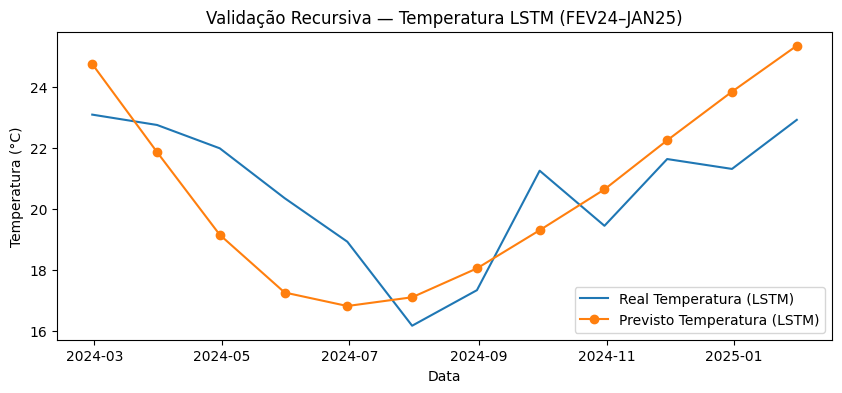

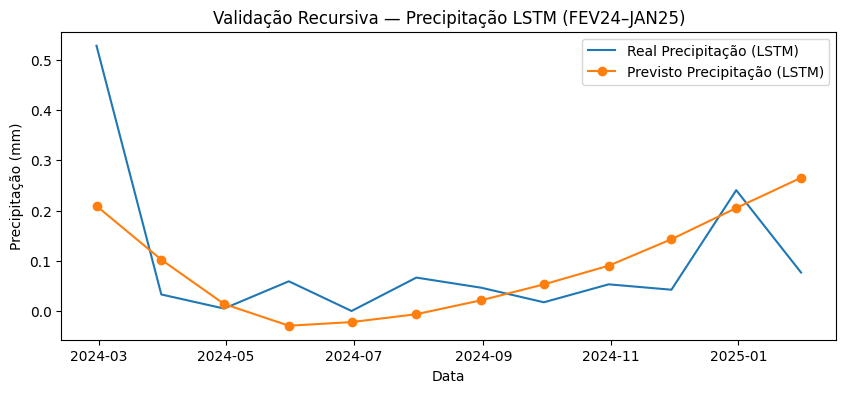

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# construir janelas deslizantes (12→1) sobre df_feat[['Temperatura','Precipitacao']]
values = df_feat[['Temperatura','Precipitacao']].values
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

def make_dataset(data, lookback=12):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i, :])  # ambos targets
    return np.array(X), np.array(y)

X_all, y_all = make_dataset(scaled, lookback=12)
# separar treino até jan/2024
cut = df_feat.index.get_loc('2024-01-31') - 12 + 1
X_tr, y_tr = X_all[:cut], y_all[:cut]
X_te, y_te = X_all[cut:cut+12], y_all[cut:cut+12]
idx_te = pd.date_range('2024-02-01', periods=12, freq='M')

# definir e treinar LSTM
model = Sequential([
    LSTM(32, input_shape=(12,2), return_sequences=False),
    Dense(2)
])
model.compile('adam', loss='mse')
model.fit(X_tr, y_tr, epochs=100, batch_size=4, verbose=0)

# prever recursivamente
preds = []
roll = scaled[:cut+12].copy()
for i, ds in enumerate(idx_te):
    x_in = roll[-12:].reshape(1,12,2)
    y_hat = model.predict(x_in, verbose=0)[0]
    preds.append(y_hat)
    roll = np.vstack([roll, y_hat])

preds = np.array(preds)
# inverter escala
preds_inv = scaler.inverse_transform(preds)
real_inv  = df_feat.loc['2024-02-01':'2025-01-31',['Temperatura','Precipitacao']].values

temp_pred = pd.Series(preds_inv[:,0], index=idx_te)
prec_pred = pd.Series(preds_inv[:,1], index=idx_te)
real_t    = pd.Series(real_inv[:,0], index=idx_te)
real_p    = pd.Series(real_inv[:,1], index=idx_te)

# métricas e gráficos (igual ao CatBoost)
mae_t,rmse_t,mape_t = metr(real_t,temp_pred)
mae_p,rmse_p,mape_p = metr(real_p,prec_pred)
print(f"LSTM (Temp) — MAE: {mae_t:.3f}, RMSE: {rmse_t:.3f}, MAPE: {mape_t:.3f}%")
print(f"LSTM (Prec) — MAE: {mae_p:.3f}, RMSE: {rmse_p:.3f}, MAPE: {mape_p:.3f}%")

for name, real, pred, ylabel in [
    ("Temperatura", real_t, temp_pred, "Temperatura (°C)"),
    ("Precipitação", real_p, prec_pred, "Precipitação (mm)")
]:
    plt.figure(figsize=(10,4))
    plt.plot(idx_te, real,   '-',  label=f"Real {name} (LSTM)",    color='tab:blue')
    plt.plot(idx_te, pred,  'o-',  label=f"Previsto {name} (LSTM)", color='tab:orange')
    plt.title(f"Validação Recursiva — {name} LSTM (FEV24–JAN25)")
    plt.xlabel("Data"); plt.ylabel(ylabel)
    plt.legend(); plt.show()

NGBoost

In [ ]:
!pip install ngboost

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 12.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=d06c0431c0d84cd7fd46f48edc5874b38ca519f0ae7dcdda7908ffb647576b77
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


[iter 0] loss=2.2555 val_loss=0.0000 scale=1.0000 norm=2.0574
[iter 100] loss=1.4679 val_loss=0.0000 scale=2.0000 norm=1.6308
[iter 200] loss=0.5674 val_loss=0.0000 scale=2.0000 norm=1.0333
[iter 300] loss=-0.2995 val_loss=0.0000 scale=2.0000 norm=0.8954
[iter 400] loss=-1.0749 val_loss=0.0000 scale=2.0000 norm=0.7940
[iter 0] loss=-1.0854 val_loss=0.0000 scale=1.0000 norm=0.6576
[iter 100] loss=-1.8161 val_loss=0.0000 scale=2.0000 norm=0.7709
[iter 200] loss=-2.4924 val_loss=0.0000 scale=2.0000 norm=0.7941
[iter 300] loss=-3.2409 val_loss=0.0000 scale=2.0000 norm=0.7339
[iter 400] loss=-3.7581 val_loss=0.0000 scale=1.0000 norm=0.3318


<ipython-input-32-377e737de9f2>:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_idx = pd.date_range('2024-02-01', periods=12, freq='M')


NGBoost (Temp) — MAE: 1.351, RMSE: 1.615, MAPE: 6.612%
NGBoost (Prec) — MAE: 0.065, RMSE: 0.101, MAPE: 110.787%


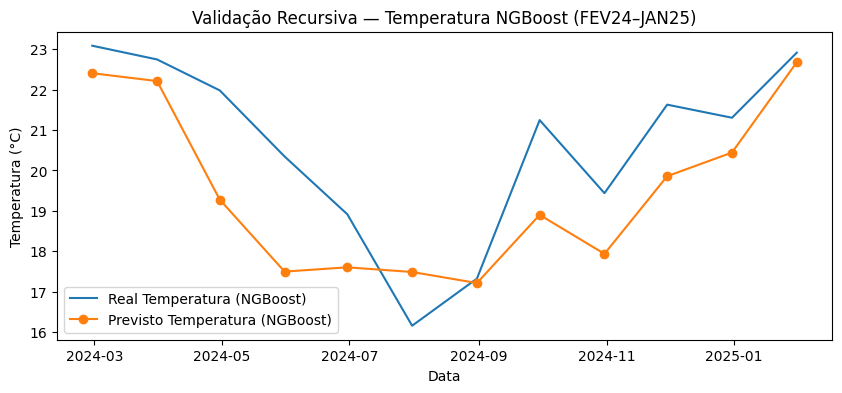

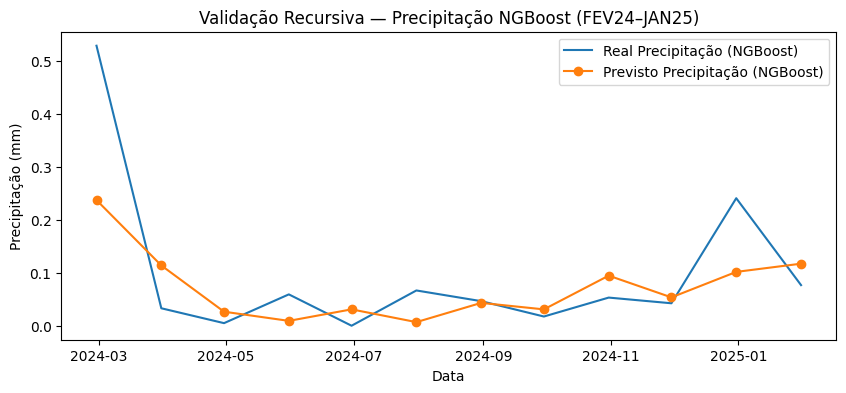

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ngboost import NGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# mesma preparação de df_feat_train/test, X_train, y_train

ngb_t = NGBRegressor(n_estimators=500, learning_rate=0.01, random_state=42)
ngb_p = NGBRegressor(n_estimators=500, learning_rate=0.01, random_state=42)
ngb_t.fit(X_train, y_t_train)
ngb_p.fit(X_train, y_p_train)

# previsão recursiva
df_roll = train_feat.copy()
forecast_idx = pd.date_range('2024-02-01', periods=12, freq='M')
pred_t, pred_p = [], []

for ds in forecast_idx:
    feat = {}
    for lag in [1,2,3]:
        prev = ds - pd.offsets.MonthEnd(lag)
        feat[f'temp_lag_{lag}'] = df_roll.at[prev,'Temperatura']
        feat[f'prec_lag_{lag}'] = df_roll.at[prev,'Precipitacao']
    m = ds.month
    feat['month_sin'] = np.sin(2*np.pi*m/12)
    feat['month_cos'] = np.cos(2*np.pi*m/12)
    X_new = pd.DataFrame([feat], index=[ds])

    pred_t.append(ngb_t.predict(X_new)[0])
    pred_p.append(ngb_p.predict(X_new)[0])
    df_roll.at[ds,'Temperatura']=pred_t[-1]
    df_roll.at[ds,'Precipitacao']=pred_p[-1]

pred_t = pd.Series(pred_t, index=forecast_idx)
pred_p = pd.Series(pred_p, index=forecast_idx)
real_t = test_feat['Temperatura'].reindex(forecast_idx)
real_p = test_feat['Precipitacao'].reindex(forecast_idx)

mae_t,rmse_t,mape_t = metr(real_t,pred_t)
mae_p,rmse_p,mape_p = metr(real_p,pred_p)
print(f"NGBoost (Temp) — MAE: {mae_t:.3f}, RMSE: {rmse_t:.3f}, MAPE: {mape_t:.3f}%")
print(f"NGBoost (Prec) — MAE: {mae_p:.3f}, RMSE: {rmse_p:.3f}, MAPE: {mape_p:.3f}%")

# gráficos
for name, real, pred, ylabel in [
    ("Temperatura", real_t, pred_t, "Temperatura (°C)"),
    ("Precipitação", real_p, pred_p, "Precipitação (mm)")
]:
    plt.figure(figsize=(10,4))
    plt.plot(forecast_idx, real,   '-', label=f"Real {name} (NGBoost)",    color='tab:blue')
    plt.plot(forecast_idx, pred,  'o-', label=f"Previsto {name} (NGBoost)", color='tab:orange')
    plt.title(f"Validação Recursiva — {name} NGBoost (FEV24–JAN25)")
    plt.xlabel("Data"); plt.ylabel(ylabel)
    plt.legend(); plt.show()

PREVISÃO FINAL

Holt–Winters

<ipython-input-96-aa0b1a2c33de>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  real_idx   = pd.date_range('2024-02-28', periods=12, freq='M')
<ipython-input-96-aa0b1a2c33de>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_idx = pd.date_range('2025-02-28', periods=4,  freq='M')


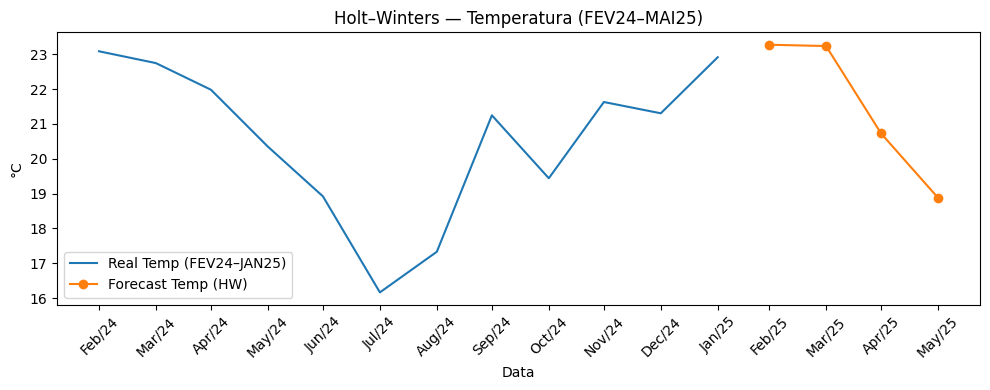

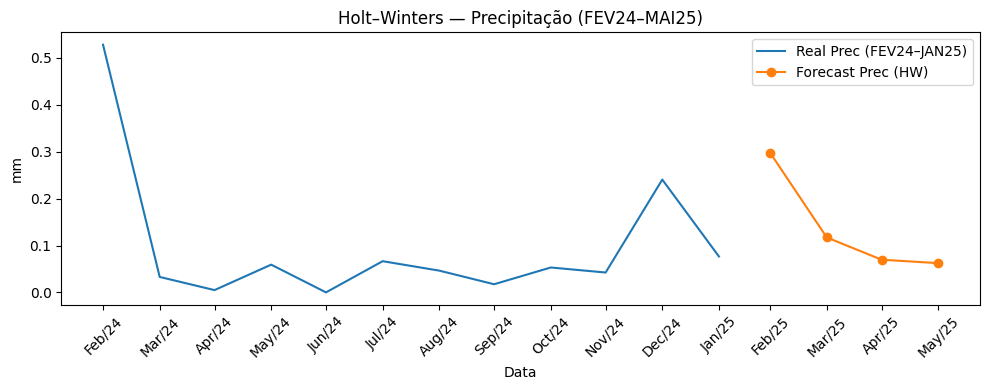

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Índices reais (validação fev/24–jan/25) e ticks completos
real_idx   = pd.date_range('2024-02-28', periods=12, freq='M')
future_idx = pd.date_range('2025-02-28', periods=4,  freq='M')
all_ticks  = list(real_idx) + list(future_idx)
labels     = [dt.strftime('%b/%y') for dt in all_ticks]

# Ajuste HW até janeiro/2025
hw_temp = ExponentialSmoothing(
    df_feat['Temperatura'].loc[:'2025-01-31'],
    trend='add', seasonal='add', seasonal_periods=12
).fit(optimized=True)
hw_prec = ExponentialSmoothing(
    df_feat['Precipitacao'].loc[:'2025-01-31'],
    trend='add', seasonal='add', seasonal_periods=12
).fit(optimized=True)

# Forecast fev–mai/2025
temp_fc_hw = hw_temp.forecast(4)
prec_fc_hw = hw_prec.forecast(4)

# Plot — Temperatura
plt.figure(figsize=(10,4))
# série real dos últimos 12 meses
plt.plot(real_idx,
         df_feat['Temperatura'].loc[real_idx],
         '-', label='Real Temp (FEV24–JAN25)', color='tab:blue')
# forecast para 4 meses seguintes
plt.plot(future_idx,
         temp_fc_hw,
         'o-', label='Forecast Temp (HW)', color='tab:orange')
plt.title("Holt–Winters — Temperatura (FEV24–MAI25)")
plt.xlabel("Data"); plt.ylabel("°C")
plt.xticks(all_ticks, labels, rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Plot — Precipitação
plt.figure(figsize=(10,4))
plt.plot(real_idx,
         df_feat['Precipitacao'].loc[real_idx],
         '-', label='Real Prec (FEV24–JAN25)', color='tab:blue')
plt.plot(future_idx,
         prec_fc_hw,
         'o-', label='Forecast Prec (HW)', color='tab:orange')
plt.title("Holt–Winters — Precipitação (FEV24–MAI25)")
plt.xlabel("Data"); plt.ylabel("mm")
plt.xticks(all_ticks, labels, rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcn5aduji/q5jc9g3e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcn5aduji/e3cqd6gr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33858', 'data', 'file=/tmp/tmpcn5aduji/q5jc9g3e.json', 'init=/tmp/tmpcn5aduji/e3cqd6gr.json', 'output', 'file=/tmp/tmpcn5aduji/prophet_modelkqklnf48/prophet_model-20250503185233.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:52:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
<ipython-input-94-05ac985eb87a>:26: FutureWarning

Temperatura FEV–MAI/25: [23.81963326 23.85295381 21.44511273 19.63894626]


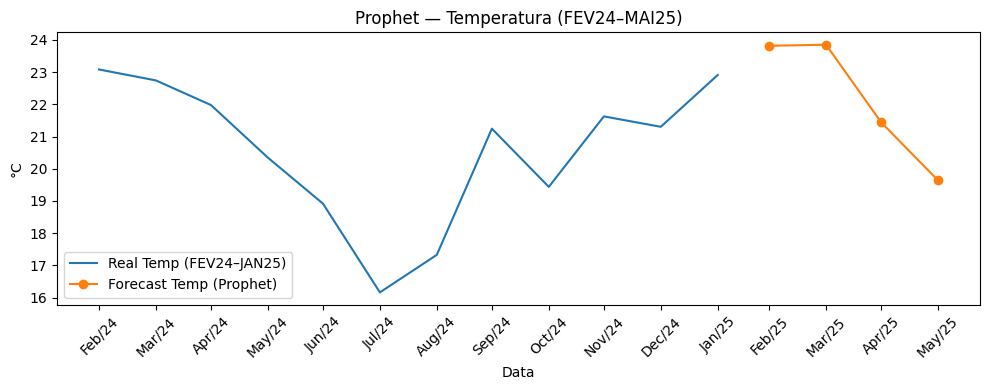

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcn5aduji/dejukd34.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcn5aduji/82nq02id.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76093', 'data', 'file=/tmp/tmpcn5aduji/dejukd34.json', 'init=/tmp/tmpcn5aduji/82nq02id.json', 'output', 'file=/tmp/tmpcn5aduji/prophet_modelh7_q1tq7/prophet_model-20250503185233.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:52:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Precipitação FEV–MAI/25: [0.33019325 0.10255017 0.06115969 0.06082675]


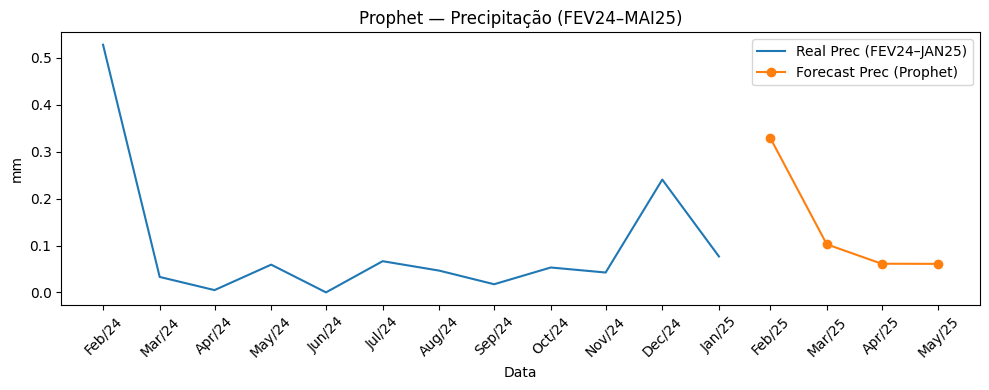

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

Preparar DataFrame para Prophet (Temperatura)
df_p = df_feat.reset_index()
first_col = df_p.columns[0]                # pega o nome da primeira coluna
df_p = df_p.rename(columns={first_col: "ds", "Temperatura": "y"})[["ds","y"]]

# Ajustar modelo até janeiro/2025
m = Prophet(yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False)
m.fit(df_p[df_p["ds"] <= "2025-01-31"])

# Criar horizonte fev–mai/2025 e prever
future = m.make_future_dataframe(periods=4, freq="M")
fc     = m.predict(future).set_index("ds")
future_idx = pd.to_datetime(["2025-02-28","2025-03-31","2025-04-30","2025-05-31"])
temp_fc_pr = fc.loc[future_idx, "yhat"]

# DEBUG: confira os valores
print("Temperatura FEV–MAI/25:", temp_fc_pr.values)

# Montar índice real (fev/24–jan/25) e ticks
real_idx  = pd.date_range("2024-02-28", periods=12, freq="M")
all_ticks = list(real_idx) + list(future_idx)
labels    = [d.strftime("%b/%y") for d in all_ticks]

# Plot Temperatura
plt.figure(figsize=(10,4))
plt.plot(real_idx,
         df_feat["Temperatura"].loc[real_idx],
         '-', label="Real Temp (FEV24–JAN25)", color="tab:blue")
plt.plot(future_idx,
         temp_fc_pr,
         'o-', label="Forecast Temp (Prophet)", color="tab:orange")
plt.title("Prophet — Temperatura (FEV24–MAI25)")
plt.xlabel("Data"); plt.ylabel("°C")
plt.xticks(all_ticks, labels, rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# ——————————————————————————————————————————————

# Agora para Precipitação
df_p2 = df_feat.reset_index()
first_col = df_p2.columns[0]
df_p2 = df_p2.rename(columns={first_col: "ds", "Precipitacao": "y"})[["ds","y"]]

m2 = Prophet(yearly_seasonality=True,
             weekly_seasonality=False,
             daily_seasonality=False)
m2.fit(df_p2[df_p2["ds"] <= "2025-01-31"])

future2    = m2.make_future_dataframe(periods=4, freq="M")
fc2        = m2.predict(future2).set_index("ds")
prec_fc_pr = fc2.loc[future_idx, "yhat"]

print("Precipitação FEV–MAI/25:", prec_fc_pr.values)

plt.figure(figsize=(10,4))
plt.plot(real_idx,
         df_feat["Precipitacao"].loc[real_idx],
         '-', label="Real Prec (FEV24–JAN25)", color="tab:blue")
plt.plot(future_idx,
         prec_fc_pr,
         'o-', label="Forecast Prec (Prophet)", color="tab:orange")
plt.title("Prophet — Precipitação (FEV24–MAI25)")
plt.xlabel("Data"); plt.ylabel("mm")
plt.xticks(all_ticks, labels, rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

NGBoost

[iter 0] loss=2.2679 val_loss=0.0000 scale=1.0000 norm=2.0916
[iter 100] loss=1.5098 val_loss=0.0000 scale=2.0000 norm=1.7067
[iter 200] loss=0.6254 val_loss=0.0000 scale=2.0000 norm=1.0469
[iter 0] loss=-0.8846 val_loss=0.0000 scale=1.0000 norm=0.7175
[iter 100] loss=-1.8600 val_loss=0.0000 scale=2.0000 norm=0.8218
[iter 200] loss=-2.6664 val_loss=0.0000 scale=1.0000 norm=0.4016


<ipython-input-52-dc1dd5fe29b9>:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_idx = pd.date_range('2025-02-28', periods=4, freq='M')
<ipython-input-52-dc1dd5fe29b9>:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  real_idx = pd.date_range('2024-02-28', periods=12, freq='M')


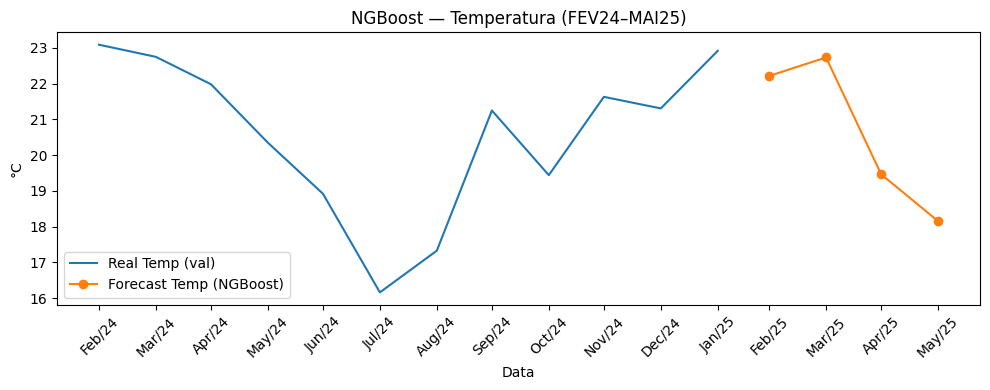

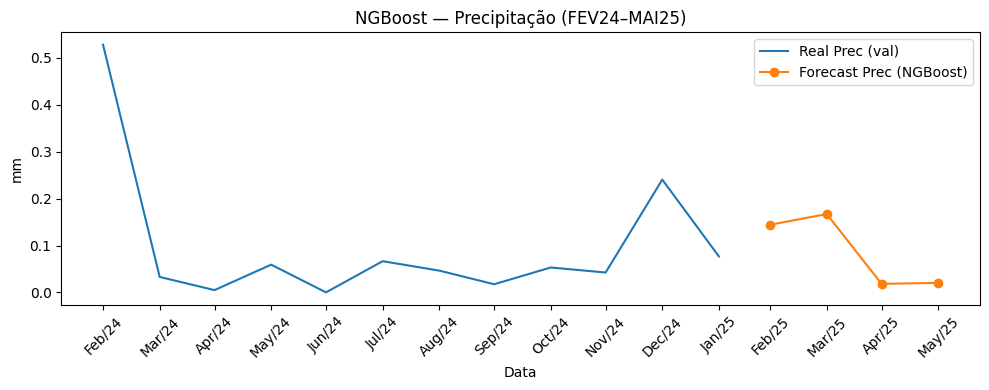

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ngboost import NGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Preparar features de lags 1–3 e cíclicos até jan/2025
df = df_feat.copy()
for lag in [1,2,3]:
    df[f'temp_lag_{lag}'] = df['Temperatura'].shift(lag)
    df[f'prec_lag_{lag}'] = df['Precipitacao'].shift(lag)
df['month_sin'] = np.sin(2*np.pi*df.index.month/12)
df['month_cos'] = np.cos(2*np.pi*df.index.month/12)
df = df.dropna()

# Treino até jan/2025 e forecast recursivo 4 passos
train = df.loc[:'2025-01-31']
X_cols = [c for c in df.columns if 'lag' in c or 'month_' in c]
X_train, y_t = train[X_cols], train['Temperatura']
_, y_p = train[X_cols], train['Precipitacao']

ngb_t = NGBRegressor(n_estimators=300, learning_rate=0.01, random_state=42).fit(X_train, y_t)
ngb_p = NGBRegressor(n_estimators=300, learning_rate=0.01, random_state=42).fit(X_train, y_p)

# Recursivo fev–mai/2025
future_idx = pd.date_range('2025-02-28', periods=4, freq='M')
df_roll = train.copy()
pred_t, pred_p = [], []
for ds in future_idx:
    feats = {}
    for lag in [1,2,3]:
        prev = ds - pd.offsets.MonthEnd(lag)
        feats[f'temp_lag_{lag}'] = df_roll.at[prev,'Temperatura']
        feats[f'prec_lag_{lag}'] = df_roll.at[prev,'Precipitacao']
    feats['month_sin'] = np.sin(2*np.pi*ds.month/12)
    feats['month_cos'] = np.cos(2*np.pi*ds.month/12)
    x_new = pd.DataFrame([feats], index=[ds])
    t_hat = ngb_t.predict(x_new)[0]; p_hat = ngb_p.predict(x_new)[0]
    pred_t.append(t_hat); pred_p.append(p_hat)
    df_roll.at[ds,'Temperatura'] = t_hat; df_roll.at[ds,'Precipitacao'] = p_hat

# real de validação (fev/24–jan/25)
real_idx = pd.date_range('2024-02-28', periods=12, freq='M')
real_temp = df_feat['Temperatura'].loc[real_idx]
real_prec = df_feat['Precipitacao'].loc[real_idx]

# montar ticks: primeiros 12 para real, depois 4 para forecast
all_ticks = list(real_idx) + list(future_idx)
labels    = [dt.strftime('%b/%y') for dt in all_ticks]

# Plot — Temperatura
plt.figure(figsize=(10,4))
plt.plot(real_idx, real_temp,     '-',  label='Real Temp (val)',    color='tab:blue')
plt.plot(future_idx, pred_t,     'o-', label='Forecast Temp (NGBoost)', color='tab:orange')
plt.title("NGBoost — Temperatura (FEV24–MAI25)")
plt.xlabel("Data"); plt.ylabel("°C")
plt.xticks(all_ticks, labels, rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Plot — Precipitação
plt.figure(figsize=(10,4))
plt.plot(real_idx, real_prec,     '-',  label='Real Prec (val)',    color='tab:blue')
plt.plot(future_idx, pred_p,     'o-', label='Forecast Prec (NGBoost)', color='tab:orange')
plt.title("NGBoost — Precipitação (FEV24–MAI25)")
plt.xlabel("Data"); plt.ylabel("mm")
plt.xticks(all_ticks, labels, rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

LSTM (TensorFlow/Keras)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
LSTM (Temp) FEV24–JAN25 — MAE: 1.126, RMSE: 1.392, MAPE: 5.481%
LSTM (Prec) FEV24–JAN25 — MAE: 0.114, RMSE: 0.146, MAPE: 186.375%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


<ipython-input-51-ff58254d3b6e>:86: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range('2025-02-28', periods=4, freq='M')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


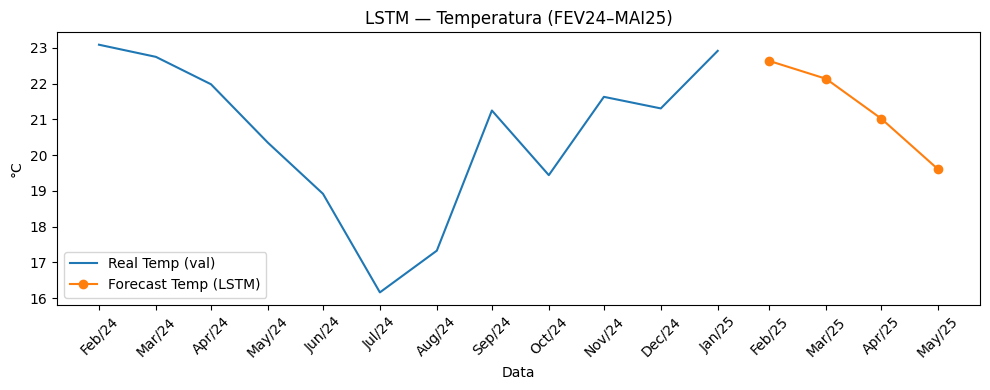

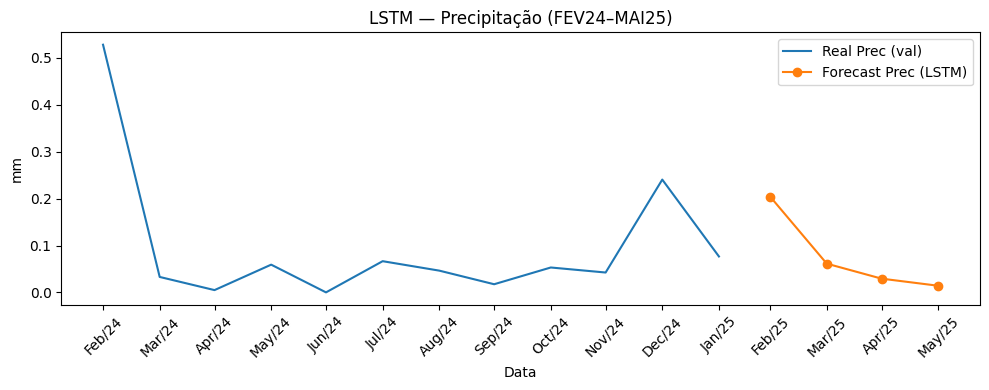

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Preparar df_feat e escaladores
df = df_feat[['Temperatura','Precipitacao']].copy()

scaler_temp = MinMaxScaler()
scaler_prec = MinMaxScaler()
temp_scaled = scaler_temp.fit_transform(df[['Temperatura']].values)
prec_scaled = scaler_prec.fit_transform(df[['Precipitacao']].values)

# Montar janelas (12 lags → 1 passo) para cada target
n_lags = 12
X_temp, y_temp = [], []
X_prec, y_prec = [], []

for i in range(n_lags, len(df)):
    X_temp.append(temp_scaled[i-n_lags:i, 0])
    y_temp.append(temp_scaled[i, 0])
    X_prec.append(prec_scaled[i-n_lags:i, 0])
    y_prec.append(prec_scaled[i, 0])

X_temp = np.array(X_temp).reshape(-1, n_lags, 1)
y_temp = np.array(y_temp)
X_prec = np.array(X_prec).reshape(-1, n_lags, 1)
y_prec = np.array(y_prec)

dates = df.index[n_lags:]  # índices correspondentes aos y's

# Separar treino até 2024‑01‑31 e validação fev/24–jan/25 (12 pontos)
cutoff = pd.to_datetime('2024-01-31')
mask_train = dates <= cutoff

Xt_train, yt_train = X_temp[mask_train], y_temp[mask_train]
Xp_train, yp_train = X_prec[mask_train], y_prec[mask_train]

Xv_temp, yv_temp = X_temp[~mask_train], y_temp[~mask_train]
Xv_prec, yv_prec = X_prec[~mask_train], y_prec[~mask_train]

idx_val = dates[~mask_train]  # 12 meses fev24–jan25

# Definir e treinar LSTM separado para cada target
def train_lstm(X_tr, y_tr):
    model = Sequential([LSTM(32, input_shape=(n_lags,1)), Dense(1)])
    model.compile('adam','mse')
    es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model.fit(X_tr, y_tr, epochs=200, batch_size=4, callbacks=[es], verbose=0)
    return model

model_temp = train_lstm(Xt_train, yt_train)
model_prec = train_lstm(Xp_train, yp_train)

# Prever in‑sample validação e inverter escala
yt_pred_scaled = model_temp.predict(Xv_temp)
yp_pred_scaled = model_prec.predict(Xv_prec)

yt_pred = scaler_temp.inverse_transform(yt_pred_scaled).ravel()
yp_pred = scaler_prec.inverse_transform(yp_pred_scaled).ravel()

real_temp = df['Temperatura'].loc[idx_val]
real_prec = df['Precipitacao'].loc[idx_val]

# Métricas validação
def calc_metrics(real, pred):
    mae   = mean_absolute_error(real, pred)
    rmse  = np.sqrt(mean_squared_error(real, pred))
    mape  = np.mean(np.abs((real - pred)/real).replace(np.inf,np.nan)) *100
    return mae, rmse, mape

m_t = calc_metrics(real_temp, yt_pred)
m_p = calc_metrics(real_prec, yp_pred)

print(f"LSTM (Temp) FEV24–JAN25 — MAE: {m_t[0]:.3f}, RMSE: {m_t[1]:.3f}, MAPE: {m_t[2]:.3f}%")
print(f"LSTM (Prec) FEV24–JAN25 — MAE: {m_p[0]:.3f}, RMSE: {m_p[1]:.3f}, MAPE: {m_p[2]:.3f}%")

# Forecast recursivo para fev/25–mai/25 (4 meses)
last_temp = temp_scaled[-n_lags:].reshape(1,n_lags,1)
last_prec = prec_scaled[-n_lags:].reshape(1,n_lags,1)

future_dates = pd.date_range('2025-02-28', periods=4, freq='M')
fc_temp, fc_prec = [], []

for _ in future_dates:
    t_s = model_temp.predict(last_temp)[0,0]
    p_s = model_prec.predict(last_prec)[0,0]
    fc_temp.append(t_s); fc_prec.append(p_s)
    last_temp = np.concatenate([last_temp[:,1:,:], [[[t_s]]]], axis=1)
    last_prec = np.concatenate([last_prec[:,1:,:], [[[p_s]]]], axis=1)

# inverter escala
fc_temp = scaler_temp.inverse_transform(np.array(fc_temp).reshape(-1,1)).ravel()
fc_prec = scaler_prec.inverse_transform(np.array(fc_prec).reshape(-1,1)).ravel()

# Plot final com ticks customizados (corrigido)
all_ticks = list(idx_val) + list(future_dates)

labels = []
for dt in all_ticks:
    if dt in idx_val:
        # validação: usa o próprio mês
        labels.append(dt.strftime('%b/%y'))
    else:
        # forecast: também o próprio mês
        labels.append(dt.strftime('%b/%y'))

# Temperatura
plt.figure(figsize=(10,4))
plt.plot(idx_val, real_temp,    '-',  label='Real Temp (val)',    color='tab:blue')
plt.plot(future_dates, fc_temp, 'o-', label='Forecast Temp (LSTM)', color='tab:orange')
plt.title("LSTM — Temperatura (FEV24–MAI25)")
plt.xlabel("Data"); plt.ylabel("°C")
plt.xticks(all_ticks, labels, rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Precipitação
plt.figure(figsize=(10,4))
plt.plot(idx_val, real_prec,    '-',  label='Real Prec (val)',    color='tab:blue')
plt.plot(future_dates, fc_prec, 'o-', label='Forecast Prec (LSTM)', color='tab:orange')
plt.title("LSTM — Precipitação (FEV24–MAI25)")
plt.xlabel("Data"); plt.ylabel("mm")
plt.xticks(all_ticks, labels, rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


Comparaçao da previsão dos modelos

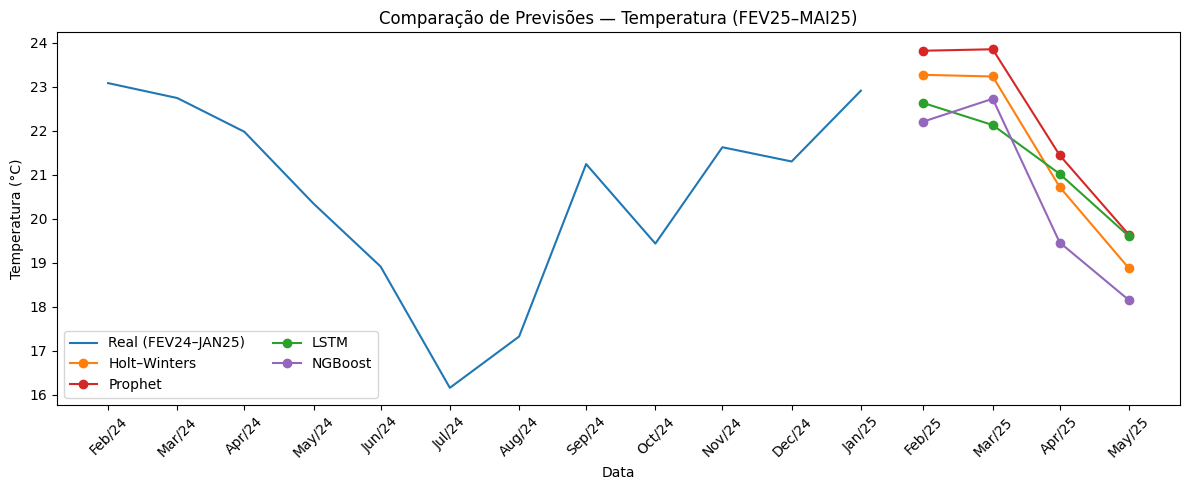

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Índices
real_idx   = pd.date_range('2024-02-28', periods=12, freq='ME')
future_idx = pd.date_range('2025-02-28', periods=4,  freq='ME')

# Série real de validação
real_temp = df_feat['Temperatura'].loc[real_idx]

# Plot comparativo
plt.figure(figsize=(12,5))

# real
plt.plot(real_idx, real_temp, '-', label='Real (FEV24–JAN25)', color='tab:blue')

models = [
    ('Holt–Winters', temp_fc_hw, 'tab:orange'),
    ('Prophet',      temp_fc_pr, 'tab:red'),
    ('LSTM',         fc_temp,    'tab:green'),
    ('NGBoost',      pred_t,     'tab:purple'),
]

for name, series, color in models:
    plt.plot(future_idx, series, 'o-', label=name, color=color)

# custom ticks
all_dates = list(real_idx) + list(future_idx)
plt.xticks(
    all_dates,
    [d.strftime('%b/%y') for d in all_dates],
    rotation=45
)

plt.title("Comparação de Previsões — Temperatura (FEV25–MAI25)")
plt.xlabel("Data")
plt.ylabel("Temperatura (°C)")
plt.tight_layout()
plt.legend(ncol=2)
plt.show()

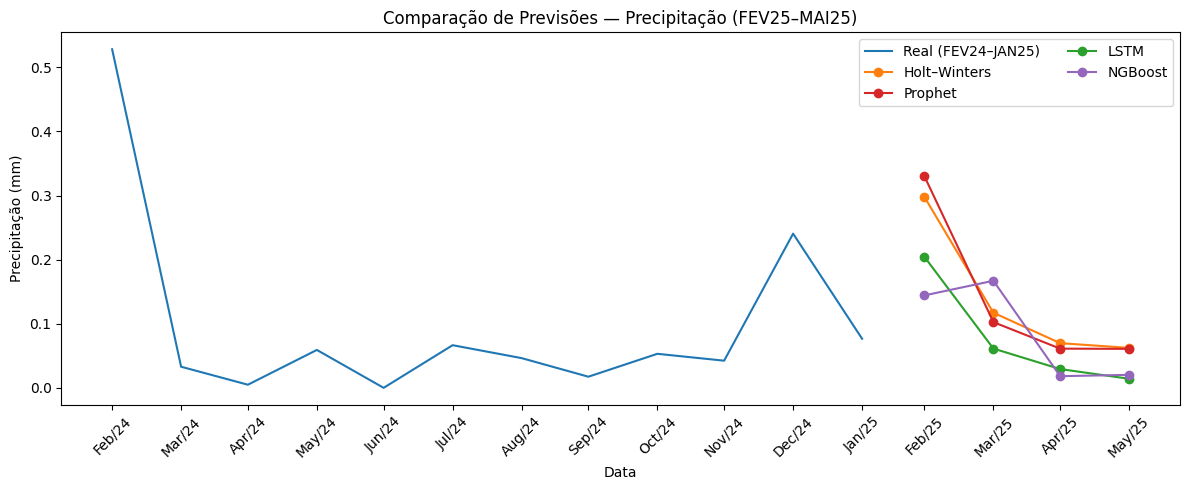

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Índices
real_idx   = pd.date_range('2024-02-28', periods=12, freq='ME')
future_idx = pd.date_range('2025-02-28', periods=4,  freq='ME')

# Série real de validação
real_prec = df_feat['Precipitacao'].loc[real_idx]

# Plot comparativo
plt.figure(figsize=(12,5))

# real
plt.plot(real_idx, real_prec, '-', label='Real (FEV24–JAN25)', color='tab:blue')

models = [
    ('Holt–Winters', prec_fc_hw, 'tab:orange'),
    ('Prophet',      prec_fc_pr, 'tab:red'),
    ('LSTM',         fc_prec,    'tab:green'),
    ('NGBoost',      pred_p,     'tab:purple'),
]

for name, series, color in models:
    plt.plot(future_idx, series, 'o-', label=name, color=color)

# custom ticks
all_dates = list(real_idx) + list(future_idx)
plt.xticks(
    all_dates,
    [d.strftime('%b/%y') for d in all_dates],
    rotation=45
)

plt.title("Comparação de Previsões — Precipitação (FEV25–MAI25)")
plt.xlabel("Data")
plt.ylabel("Precipitação (mm)")
plt.tight_layout()
plt.legend(ncol=2)
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Definir horizonte de previsão
future_idx = pd.to_datetime([
    "2025-02-28",
    "2025-03-31",
    "2025-04-30",
    "2025-05-31"
])

# Montar DataFrame de comparação
df_forecasts = pd.DataFrame({
    "HW_Temp":       temp_fc_hw.values,     # statsmodels Series
    "Prophet_Temp":  temp_fc_pr.values,     # pandas Series
    "LSTM_Temp":     fc_temp,               # numpy ndarray
    "NGBoost_Temp":  np.array(pred_t),      # lista → ndarray

    "HW_Prec":       prec_fc_hw.values,
    "Prophet_Prec":  prec_fc_pr.values,
    "LSTM_Prec":     fc_prec,               # numpy ndarray
    "NGBoost_Prec":  np.array(pred_p),
}, index=future_idx)

# Formatar índice como período mês/ano
df_forecasts.index = df_forecasts.index.to_period("M").strftime("%b/%y")

# Exibir com três casas decimais
pd.set_option("display.float_format", "{:.3f}".format)
print(df_forecasts)


        HW_Temp  Prophet_Temp  LSTM_Temp  NGBoost_Temp  HW_Prec  Prophet_Prec  \
Feb/25   23.272        23.820     23.272        22.211    0.298         0.330   
Mar/25   23.234        23.853     23.234        22.729    0.117         0.103   
Apr/25   20.724        21.445     20.724        19.463    0.070         0.061   
May/25   18.877        19.639     18.877        18.154    0.062         0.061   

        LSTM_Prec  NGBoost_Prec  
Feb/25      0.204         0.144  
Mar/25      0.061         0.167  
Apr/25      0.029         0.018  
May/25      0.014         0.020  
